# Load tapes and lob data

do this for each day otherwise memory (RAM) exceeds most computers

In [2]:
# code
from fast_tools import get_data

data = get_data(0,1)

Time taken to reach each day: 0.17849993705749512


(array([[ 0,  0,  0, ...,  0,  0,  0],
        [-6,  0,  0, ...,  0,  0,  0],
        [-6,  0,  0, ...,  0,  0,  1],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8),
 array([0.0000000e+00, 2.7900000e-01, 1.3330000e+00, ..., 3.0599635e+04,
        3.0599759e+04, 3.0599945e+04]),
 array([[1.1067000e+01, 2.6900000e+02, 1.0000000e+00],
        [1.1222000e+01, 2.6700000e+02, 2.0000000e+00],
        [1.2338000e+01, 2.7000000e+02, 2.0000000e+00],
        ...,
        [3.0599108e+04, 2.9200000e+02, 1.0000000e+00],
        [3.0599728e+04, 2.9000000e+02, 1.0000000e+00],
        [3.0599728e+04, 2.8800000e+02, 1.0000000e+00]]))

# Clean Data
Remove outliers from lob and create an additional columns noting this

FFill tapes data to get the most up to date tapes price

In [89]:
# code
import numpy as np
from numba import njit, prange

def get_tapes_window(tapes):
    dt = 60*60 # in seconds
    #stds = []
    #means = []
    w_bids = []
    w_asks = []

    t_start = 0
    start_time = 0
    z = 3.29 # 99.9%

    outside = []
    while True:
        end_time = start_time + dt
        t_end = t_start
        rolling_tapes = []
        while tapes[t_end, 0] < end_time:
            rolling_tapes += [tapes[t_end, 1]] * int(tapes[t_end,2])
            t_end += 1

        mean = np.mean(rolling_tapes)
        std = np.std(rolling_tapes)
        #means.append(mean)

        w_bid = mean - std * z
        w_ask = mean + std * z
        w_bids.append(w_bid)
        w_asks.append(w_ask)

        # look one minute a head
        local_end = t_end
        future_tapes = []
        while tapes[local_end, 0] < end_time + 60:
            future_tapes += [tapes[local_end, 1]] * int(tapes[local_end,2])
            local_end += 1

        future_tapes = np.array(future_tapes)

        n_above = len(np.where(future_tapes > w_ask)[0])
        n_below = len(np.where(future_tapes < w_bid)[0])
        if end_time % 60 !=0:
            raise ValueError
        outside.append((end_time,n_above, n_below, len(future_tapes)))

        start_time += 60
        while tapes[t_start, 0] < start_time:
            t_start += 1

        end_time += dt
        if end_time >= 8.5*60*60:
            break

    return outside, w_bids, w_asks

@njit(parallel=True)
def get_features(lob_data: np.array, 
                 lob_times: np.array, 
                 tapes: np.array, 
                 time_step_s: int, 
                 window_data: np.array,
                 ab_weight = 1, 
                 median = False, 
                 ):
    """
    Calculate features from LOB and Tapes data.

    Parameters:
    -----------
    lob_data : np.array
        Array containing the limit order book (LOB) data.
    lob_times : np.array
        Array containing timestamps for the LOB data.
    tapes : np.array
        Array containing Tapes data.
    time_step_s : int
        Time step in seconds for calculating features.
    ab_weight : float, optional
        Weight parameter for alpha and beta calculations, by default 1.
    median : bool, optional
        Whether to calculate features using median instead of mean, by default False.
    cas_cbs_window : int, optional
        Size of the window for calculating CAS and CBS, by default 800.
    daily_data : bool, optional
        Whether to calculate daily features, by default False.

    Returns:
    --------
    tuple
        A tuple containing:
        - feat_arr: np.array
            Array containing feature values.
        - features: list
            List of feature names.
        - daily_arr: dict or None
            Dictionary containing daily features or None if daily_data=False.
    """
    
    n_rows = int((8.5 * 60 * 60) / time_step_s)                         # define number of rows of output array
    features = ["MP","HIBID","LOASK","AP","WBP","WAP",                  # define features
                "TCBS","TCAS","AWS","VOL","GAP","SPREAD",
                "ALPHA", "BETA", "ZETA", "ENDT", 
                "PSTD", "LOWIN", "HIWIN", "nUoD"]
    n_features = len(features)                                          # define number of features

    feat_arr = np.zeros((n_rows, n_features), dtype=np.float64)         # array to hold feature values
    
    LA_HB_a_b = np.zeros((lob_data.shape[0]+1, 4), dtype = np.float64)  # array holding the LOASK, HIBID,
                                                                        # alpha, beta, values 

    for i in prange(lob_data.shape[0]):                                 # iterates over the LOB to fill
        row = lob_data[i]                                               # LA_HB_a_b values
        
        neg_ind = np.where(row < 0)[0]                                  # locate bid and ask prices (indicies)
        pos_ind = np.where(row > 0)[0]
        
        if len(neg_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][1] = np.nan
        else:
            LA_HB_a_b[i][1] = max(neg_ind) + 1 

        if len(pos_ind) == 0:                                           # assign HIBID, np.nan if no values
            LA_HB_a_b[i][0] = np.nan
        else:
            LA_HB_a_b[i][0] = min(pos_ind) + 1

        mid_price = (LA_HB_a_b[i][0] + LA_HB_a_b[i][1]) / 2             # calculate mid_price for alpha/beta calculations

        if np.isnan(mid_price):
            alpha = np.nan
            beta = np.nan
        else:                                                           # calculate alpha/beta using ab_weight var
            beta = 0
            for ind in neg_ind:
                beta += (-1 * row[ind]) / ((mid_price - (ind + 1)) + ab_weight)
    
            alpha = 0
            for ind in pos_ind:
                alpha += row[ind] / (((ind + 1) - mid_price) + ab_weight)
                

        LA_HB_a_b[i][2] = alpha
        LA_HB_a_b[i][3] = beta
        
    max_lob = lob_data.shape[0] - 1                                      # define max indicies for lob
    max_tapes = tapes.shape[0] - 1                                       # define max indicies for tapes
    
    start_time = 0                                                       # define start time
    lob_start = 0                                                        # define start index for lob
    tapes_start = 0                                                      # define start index for tapes
    
    cas = np.zeros(800, dtype = np.int16)                                # define an array to hold CAS values
    cbs = np.zeros(800, dtype = np.int16)                                # define an array to hold CBS values
    for row_i in range(n_rows):
        end_time = start_time + time_step_s                              # move to next time step
        lob_end = lob_start
        tapes_end = tapes_start

        # get lob end index
        while lob_times[lob_end] < end_time and lob_end < max_lob:       # move lob indicies to end time
            lob_end += 1
        
        # get tapes end index
        while tapes[tapes_end][0] < end_time and tapes_end < max_tapes:  # move tapes indicies to end time
            tapes_end += 1

        # feature calculations
        if tapes_start == tapes_end:                                     # if there is no tapes data
            AP = np.nan                                                  # set tapes features to np.nan
            VOL = np.nan
            PSTD = np.nan
            nUoD = np.nan
        else:
            tapes_slice = tapes[tapes_start:tapes_end]                   # extract tapes slice, calculate AP, VOL
            tapes_list = []
            
            for row in tapes_slice:
                for _ in range(int(row[2])):
                    tapes_list.append(row[1])

            tapes_list = np.array(tapes_list, dtype=np.int32)
            AP = np.mean(tapes_list)
            VOL = np.sum(tapes_slice[:,2])
            PSTD = np.std(tapes_list)

            tapes_price_diff = tapes_slice[:,1][1:] - tapes_slice[:,1][:-1]
            n_ups = np.sum(tapes_price_diff > 0)
            n_downs = np.sum(tapes_price_diff < 0)
            nUoD = (n_ups + 1) / (n_downs + 1) - 1

        if lob_start == lob_end:                                         # if there is no LOB data
            MP = np.nan                                                  # set lob features to np.nan
            HIBID = np.nan
            LOASK = np.nan
            SPREAD = np.nan
            TCBS = np.nan
            TCAS = np.nan
            WBP = np.nan
            WAP = np.nan
            AWS = np.nan
            ALPHA = np.nan
            BETA = np.nan
            ZETA = np.nan  
        else:
            lob_slice = lob_data[lob_start:lob_end]                       # extract slices of data 
            LA_HB_a_b_slice = LA_HB_a_b[lob_start:lob_end]                

            # midprice_calcs, alpha, beta
            if median:                                                    # calculate price features
                HIBID = np.median(LA_HB_a_b_slice[:,1])                   # using median if set to true
                LOASK = np.median(LA_HB_a_b_slice[:,0])
                ALPHA = np.median(LA_HB_a_b_slice[:,2])
                BETA = np.median(LA_HB_a_b_slice[:,3])
            else:
                HIBID = np.nanmean(LA_HB_a_b_slice[:,1])
                LOASK = np.nanmean(LA_HB_a_b_slice[:,0])
                ALPHA = np.nanmean(LA_HB_a_b_slice[:,2])
                BETA = np.nanmean(LA_HB_a_b_slice[:,3])

            MP = (HIBID + LOASK) / 2
            SPREAD = LOASK - HIBID
            ZETA = BETA - ALPHA

            if HIBID >= LOASK:
                print("WARNING: HIBID >= LOASK")

            # consolidated calcs
            cas[:] = 0                                                      # reset cas, cbs arrays for new data
            cbs[:] = 0 

            window_index = np.where(window_data[:,0] == end_time)[0]
            if len(window_index) == 1:
                w_bid = window_data[window_index[0], 4]
                w_ask = window_data[window_index[0], 5]
                LOWIN = window_data[window_index[0], 1]
                HIWIN = window_data[window_index[0], 2]
            else:
                w_bid = MP - 100
                w_ask = MP + 100
                LOWIN = 0
                HIWIN = 0

            for ci in prange(int(np.floor(w_bid) - 1), int(np.ceil(w_ask) + 2)):
                # can optimise with LOASK AND HIBID here
                                                                        # only calculate cbs between window left of MP
                cbs_vec = lob_slice[:,ci].copy() * -1                   # and less than LOASK + 100 for efficiency
                cbs_vec[cbs_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                cbs[ci] = np.sum(np.abs(np.diff(cbs_vec))) + cbs_vec[0]

                                                                        # only calculate cas between window right of MP
                cas_vec = lob_slice[:,ci].copy()                        # and greater than HIBID - 100 for efficiency
                cas_vec[cas_vec <= 0] = 0                               # idk if this breaks things for efficiency ?:
                cas[ci] = np.sum(np.abs(np.diff(cas_vec))) + cas_vec[0]

            TCBS = np.sum(cbs)                                              # Total CBS
            TCAS = np.sum(cas)                                              # Total CAS

            if TCBS == 0:                                                   # Calculate WBP, np.nan if no activity
                WBP = np.nan
            else:
                WBP = 0
                for ci in prange(800):
                    WBP += (ci + 1) * (cbs[ci] / TCBS)

            if TCAS == 0:                                                   # Calculate WAP, np.nan if no activity
                WAP = np.nan
            else:
                WAP = 0
                for ci in prange(800):
                    WAP += (ci + 1) * (cas[ci] / TCAS)

            AWS = WAP - WBP                                                 # Activity weighted spread calc

        # feature setting
        feat_arr[row_i][features.index("AP")] = AP                          # set the values to the feat_arr
        feat_arr[row_i][features.index("VOL")] = VOL
        feat_arr[row_i][features.index("MP")] = MP
        feat_arr[row_i][features.index("HIBID")] = HIBID
        feat_arr[row_i][features.index("LOASK")] = LOASK
        feat_arr[row_i][features.index("SPREAD")] = SPREAD
        feat_arr[row_i][features.index("TCAS")] = TCAS
        feat_arr[row_i][features.index("TCBS")] = TCBS
        feat_arr[row_i][features.index("WAP")] = WAP
        feat_arr[row_i][features.index("WBP")] = WBP
        feat_arr[row_i][features.index("AWS")] = AWS
        feat_arr[row_i][features.index("ALPHA")] = ALPHA
        feat_arr[row_i][features.index("BETA")] = BETA
        feat_arr[row_i][features.index("ZETA")] = ZETA
        feat_arr[row_i][features.index("GAP")] = MP - AP
        feat_arr[row_i][features.index("ENDT")] = end_time
        feat_arr[row_i][features.index("PSTD")] = PSTD
        feat_arr[row_i][features.index("LOWIN")] = LOWIN
        feat_arr[row_i][features.index("HIWIN")] = HIWIN
        feat_arr[row_i][features.index("nUoD")] = nUoD


        # adjust start times
        start_time = end_time                                                # Set the next start times and 
        lob_start = lob_end                                                  # indicies to the last end times / indicies
        tapes_start = tapes_end

    return feat_arr, features

for lob, lob_times, tapes in data:
    outside, w_bids, w_asks = get_tapes_window(tapes)
    window_data = np.zeros((len(outside), 6), dtype = float)
    for i in range(len(outside)):
        window_data[i][:4] = outside[i]
        window_data[i][4] = w_bids[i]
        window_data[i][5] = w_asks[i]

    features = get_features(lob, lob_times, tapes, 60, window_data)

In [90]:
import pandas as pd

df = pd.DataFrame(features[0], columns = features[1])
df["WMP"] = (df["WBP"] + df["WAP"]) / 2
df["MP_diff(y)"] = df["MP"].diff(1)
df.describe()

,MP,HIBID,LOASK,AP,WBP,WAP,TCBS,TCAS,AWS,VOL,...,ALPHA,BETA,ZETA,ENDT,PSTD,LOWIN,HIWIN,nUoD,WMP,MP_diff(y)
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.0,510.000000,510.000000,510.000000,509.000000
mean,286.035800,279.601927,292.469674,281.560707,270.956016,292.588977,1018.898039,666.282353,21.632961,94.060784,...,1.841453,3.452572,1.611119,15330.000000,3.833884,0.0,0.047059,-0.096779,281.772496,0.045467
std,11.977415,12.768949,14.883389,11.893899,15.788646,12.656252,349.558112,208.358263,15.750608,14.595335,...,0.511057,1.002793,0.920204,8842.115132,0.726250,0.0,0.640589,0.248906,11.946155,8.318084
min,250.568493,233.357496,253.757991,251.489796,224.682692,259.973251,204.000000,202.000000,4.542830,54.000000,...,0.538498,0.746761,-1.015538,60.000000,2.103878,0.0,0.000000,-0.647059,248.004464,-33.640400
25%,279.929176,273.170215,286.403618,274.895143,262.511816,286.031861,779.250000,511.250000,12.292414,83.000000,...,1.507612,2.771704,0.978558,7695.000000,3.281932,0.0,0.000000,-0.276515,274.555338,-3.363210
50%,289.214136,284.755665,292.735047,286.552222,278.311070,294.445186,963.000000,660.500000,14.633301,94.000000,...,1.891684,3.474120,1.540967,15330.000000,3.803233,0.0,0.000000,-0.133333,286.671618,-0.538160
75%,293.223540,288.399743,297.924144,289.620837,282.220354,298.825185,1206.750000,806.750000,18.044078,104.000000,...,2.188950,4.014576,2.153808,22965.000000,4.322434,0.0,0.000000,0.052632,289.768441,2.956135
max,319.129438,298.309117,348.053254,298.530000,291.897314,337.056834,2479.000000,1275.000000,76.150552,140.000000,...,3.473525,7.030652,5.084442,30600.000000,6.094415,0.0,12.000000,0.916667,303.925951,37.173961


In [93]:
df

,MP,HIBID,LOASK,AP,WBP,WAP,TCBS,TCAS,AWS,VOL,...,ALPHA,BETA,ZETA,ENDT,PSTD,LOWIN,HIWIN,nUoD,WMP,MP_diff(y)
0,265.814778,259.788018,271.841538,262.029851,236.790535,282.000831,1289.0,1204.0,45.210295,67.0,...,2.546072,3.598042,1.051970,60.0,4.088463,0.0,0.0,-0.500000,259.395683,NaN
1,260.504993,258.206847,262.803138,260.669811,228.672641,279.127962,1897.0,844.0,50.455321,106.0,...,2.190554,3.261417,1.070863,120.0,3.985165,0.0,0.0,0.437500,253.900302,-5.309786
2,265.263047,262.929478,267.596615,264.000000,235.558824,282.310867,1768.0,727.0,46.752043,89.0,...,1.830815,4.571049,2.740233,180.0,2.990622,0.0,0.0,-0.235294,258.934845,4.758054
3,264.908689,262.751105,267.066274,263.000000,242.977695,280.393509,1345.0,986.0,37.415814,86.0,...,2.584140,4.643347,2.059208,240.0,3.106632,0.0,0.0,-0.550000,261.685602,-0.354357
4,265.717914,263.077540,268.358289,263.102564,240.495146,281.827652,1442.0,1056.0,41.332506,78.0,...,2.311307,3.945691,1.634385,300.0,3.299533,0.0,0.0,0.000000,261.161399,0.809225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,290.823338,287.748370,293.898305,289.822917,262.212719,310.930890,1368.0,955.0,48.718171,96.0,...,2.032066,2.435379,0.403314,30360.0,5.228119,0.0,0.0,0.111111,286.571805,-2.472854
506,304.298425,293.325984,315.270866,293.675000,275.660162,316.156391,1486.0,665.0,40.496229,80.0,...,1.295897,4.784250,3.488353,30420.0,2.178159,0.0,0.0,0.000000,295.908276,13.475088
507,295.507225,286.226879,304.787572,289.133333,262.505993,310.785872,1168.0,906.0,48.279879,105.0,...,1.425354,2.391568,0.966214,30480.0,4.485037,0.0,0.0,-0.125000,286.645933,-8.791200
508,292.192044,289.196159,295.187929,290.021277,263.860664,312.310627,1055.0,1101.0,48.449963,94.0,...,2.183961,3.156712,0.972751,30540.0,3.448647,0.0,0.0,0.062500,288.085645,-3.315182


# Extract features from LOB and Tapes

get mean, std, trend, delta from 60 min segments

In [112]:
# code

features = ["TCAS", "TCBS", "ALPHA", "BETA", "ZETA",
            "WMP", "AWS", "VOL", "GAP", "nUoD", "PSTD"]

sum_features = ["LOWIN", "HIWIN"]

y_feat = "MP_diff(y)"

X_df = pd.DataFrame()

for i in range(len(df) - 60):
    train_segment = df[i:i+60]
    test_segment = df[i+60:i+61]

    row = {}
    for f in features:
        # std
        row[f+"_std"] = np.std(train_segment[f])
        # mean
        row[f+"_mean"] = np.mean(train_segment[f])
        # delta
        row[f+"_delta"] = train_segment[f].iloc[-1] - train_segment[f].iloc[0]
        # trend
        # ####### # # #  do this

    for f in sum_features:
        row[f+"_sum"] = np.sum(train_segment[f])

    row[y_feat] = test_segment[y_feat].iloc[0]

    X_df = pd.concat([X_df, pd.DataFrame(row, index = test_segment["ENDT"])])

X_df

,TCAS_std,TCAS_mean,TCAS_delta,TCBS_std,TCBS_mean,TCBS_delta,ALPHA_std,ALPHA_mean,ALPHA_delta,BETA_std,...,GAP_delta,nUoD_std,nUoD_mean,nUoD_delta,PSTD_std,PSTD_mean,PSTD_delta,LOWIN_sum,HIWIN_sum,MP_diff(y)
ENDT,,,,,,,,,,,,,,,,,,,,,
3660.0,170.659358,778.983333,-800.0,442.372433,1341.216667,-818.0,0.659799,1.567495,-1.176586,1.014749,...,25.799518,0.276989,-0.128074,0.180000,0.731317,3.804950,-0.083088,0.0,0.0,8.289241
3720.0,174.518559,763.150000,-590.0,451.720495,1330.166667,-1271.0,0.657178,1.536192,-1.522655,1.027195,...,35.976862,0.274198,-0.118074,-0.337500,0.732061,3.806590,0.201702,0.0,0.0,-33.640400
3780.0,177.742463,757.183333,-241.0,449.843317,1312.583333,-926.0,0.655731,1.534631,0.266062,1.045622,...,3.591287,0.264489,-0.127638,0.098930,0.744742,3.821635,1.897251,0.0,0.0,-2.205879
3840.0,179.022016,754.866667,-398.0,446.806364,1301.200000,-260.0,0.657462,1.537593,-0.575570,1.047074,...,-2.286608,0.267390,-0.120384,0.750000,0.746150,3.851016,1.646833,0.0,0.0,7.905300
3900.0,177.673752,748.266667,-466.0,447.086825,1298.266667,-273.0,0.643931,1.523878,-0.550086,1.127842,...,0.282176,0.261567,-0.112197,-0.058824,0.742758,3.855054,0.049430,0.0,0.0,-2.920985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30360.0,178.205375,845.333333,166.0,333.649527,1385.400000,915.0,0.437973,1.764666,-0.143816,0.725498,...,0.227716,0.255992,-0.062002,0.355556,0.779978,4.068622,-0.199249,0.0,1.0,-2.472854
30420.0,177.264425,850.083333,282.0,330.636499,1390.850000,474.0,0.438657,1.765987,0.203721,0.718263,...,-1.392612,0.255030,-0.055151,0.182540,0.793661,4.090518,2.503863,0.0,1.0,13.475088
30480.0,177.400528,849.950000,-408.0,324.437518,1400.716667,892.0,0.442673,1.757113,-1.053919,0.749819,...,10.198971,0.255118,-0.053960,-0.130435,0.812192,4.081416,-2.842435,0.0,0.0,-8.791200


In [175]:
x_features = list(X_df)
x_features.remove(y_feat)

X = X_df[x_features]
y = X_df[y_feat]

In [203]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X contains your input features and y contains your target values
# X shape: (number of samples, 35)

# Step 1: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Normalize the input features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

5.119522751754712


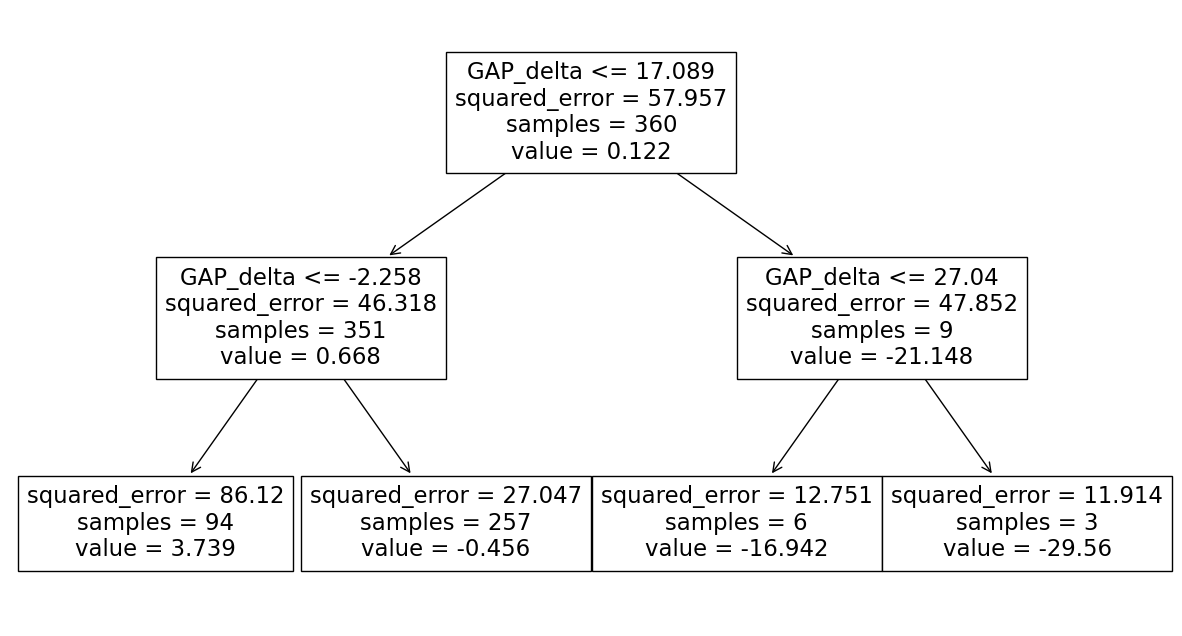

In [211]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

DTR = DecisionTreeRegressor(max_depth=2)
DTR.fit(X_train, y_train)

ypred = DTR.predict(X_test)
print(mean_absolute_error(ypred, y_test))

plt.figure(figsize=(15,8))
plot_tree(DTR, feature_names=x_features)
plt.show()

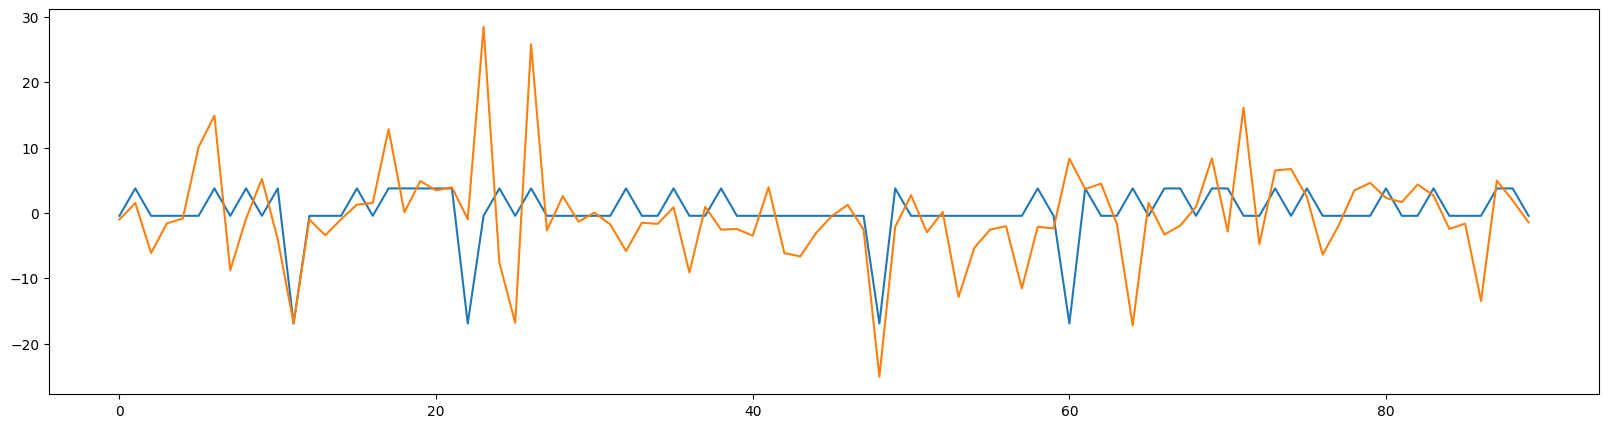

In [212]:
plt.figure(figsize=(20,5))
plt.plot(ypred)
plt.plot(y_test.to_numpy())

In [171]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_regression_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu',input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output layer with single neuron for regression
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

input_shape = (len(x_features),)
regression_model = create_regression_model(input_shape)

# Display model architecture
regression_model.summary()

c:\Users\wwden\OneDrive\Documents\GitHub\dsmp-2024-group-19\venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 64)             │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,529 (25.50 KB)

 Trainable params: 6,529 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

In [173]:
history = regression_model.fit(X_train_normalized, y_train, epochs=100, batch_size=1, validation_split=0.2)

Epoch 1/100


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5103 - val_loss: 4.9907
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7870 - val_loss: 5.1084
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9844 - val_loss: 5.1361
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5994 - val_loss: 5.1775
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9682 - val_loss: 5.0891
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2558 - val_loss: 5.0464
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8445 - val_loss: 4.8344
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0674 - val_loss: 4.8654
Epoch 9/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2371 - val_loss: 4.7812
Epoch 10/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6957 - val_loss: 4.7187
Epoch 11/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7591 - val_loss: 4.7971
Epoch 12/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

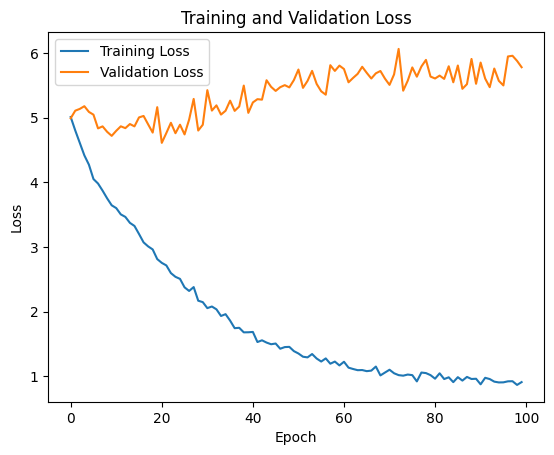

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0013 
Test Loss: 5.921733856201172


In [174]:
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

test_loss = regression_model.evaluate(X_test_normalized, y_test)

# Print the test loss
print("Test Loss:", test_loss)

# Save features

for use in models